<a href="https://colab.research.google.com/github/srivardhan-kondu/Explainable-Brain-Tumor-Detection-model-using-Masked-Autoencoders-and-Grad-CAM/blob/main/Explainable_Brain_Tumor_Detection_model_using_Masked_Autoencoders_and_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/MyDrive/brain_tumor_dataset'

In [4]:


img_size = (224, 224)
batch_size = 32


In [5]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [7]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['no', 'yes']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

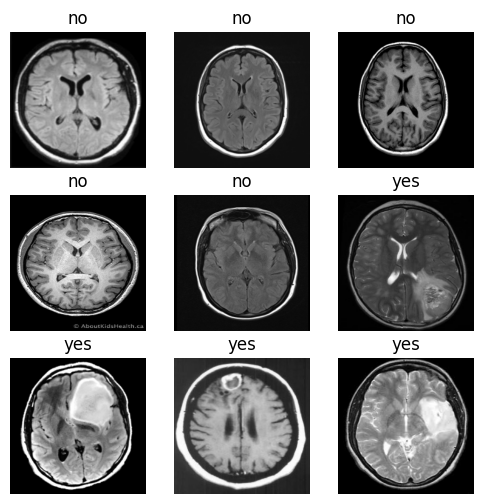

In [9]:

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [10]:

from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [11]:
import tensorflow as tf

In [12]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])


In [13]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,788 (16.09 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [18]:

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.4695 - loss: 0.7315 - val_accuracy: 0.3800 - val_loss: 0.7352 - learning_rate: 1.0000e-04
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5771 - loss: 0.6504 - val_accuracy: 0.5600 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6679 - loss: 0.6095 - val_accuracy: 0.5800 - val_loss: 0.6514 - learning_rate: 1.0000e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7144 - loss: 0.5699 - val_accuracy: 0.7400 - val_loss: 0.6211 - learning_rate: 1.0000e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7388 - loss: 0.5424 - val_accuracy: 0.7600 - val_loss: 0.5961 - learning_rate: 1.0000e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7720 - loss: 0.5075 - val_accuracy: 0.7800 - val_loss: 0.5754 - learning_rate: 1.0000e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8156 - loss: 0.4720 - val_

In [19]:
total_accuracy = fine_tune_history.history['accuracy']
total_val_accuracy = fine_tune_history.history['val_accuracy']

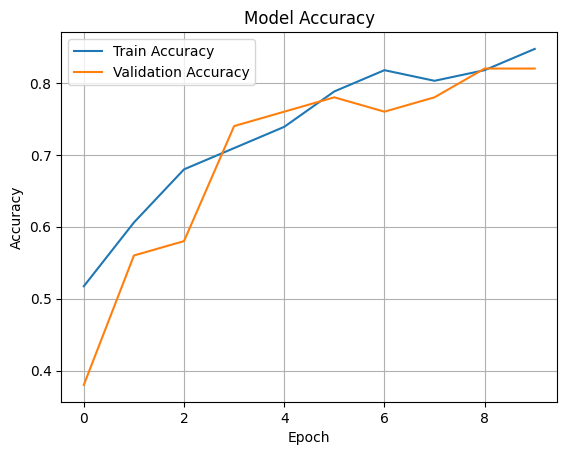

In [20]:
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

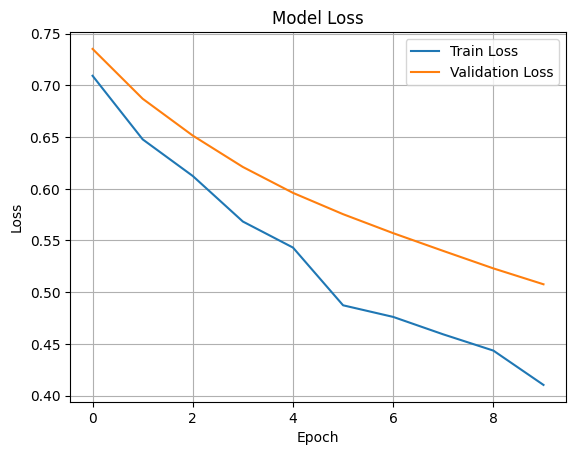

In [21]:
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
epochs_ran = len(fine_tune_history.history['accuracy'])

print(f"Training completed in {epochs_ran} epochs\n")

print(f"Final Training Accuracy     : {fine_tune_history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy   : {fine_tune_history.history['val_accuracy'][-1]*100:.2f}%")

print(f"Final Training Loss         : {fine_tune_history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss       : {fine_tune_history.history['val_loss'][-1]:.4f}")

Training completed in 10 epochs

Final Training Accuracy     : 84.73%
Final Validation Accuracy   : 82.00%
Final Training Loss         : 0.4103
Final Validation Loss       : 0.5077


In [24]:
# Step 1: Save model (SavedModel format)
import os

save_dir = '/content/drive/MyDrive/brain_tumor_model_saved.keras'  # Added .keras extension
if not os.path.exists(save_dir):
    # This part is not strictly necessary with the .keras extension,
    # but it's good practice if you were saving to a directory using model.export
    # or if you wanted to save other files alongside the model.keras file.
    # In this case, model.save() with .keras saves as a single file.
    pass

model.save(save_dir)
print("Model saved to:", save_dir)

Model saved to: /content/drive/MyDrive/brain_tumor_model_saved.keras
